# **Accident Severity Classification**

In [4]:


import numpy as np
import pandas as pd 
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import seaborn as sns
sns.set()
import math

warnings.filterwarnings('ignore')
%matplotlib inline



import os
print(os.listdir(r"C:\Users\ayanb\Downloads\RS1"))



['accident-severity-classification-shirley-ariel.ipynb', 'Accident_Information.csv', 'Vehicle_Information.csv']


# **2. Data Preparation**
## **2.1 Load Data**

In [6]:
#Load Data and encode to latin
acc = pd.read_csv(r'C:\Users\ayanb\Downloads\RS1\Accident_Information.csv', encoding = 'latin')
veh = pd.read_csv(r'C:\Users\ayanb\Downloads\RS1\Vehicle_Information.csv', encoding = 'latin')

# Merging two data sets into one with inner join by index
df = pd.merge(veh, acc, how = 'inner', on = 'Accident_Index')

#Check data sample
print(df.shape)
df.head()

(2058408, 57)


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_y,InScotland
0,200501BS00002,36 - 45,3.0,Data missing or out of range,NaN,8268.0,NaN,NaN,Journey as part of work,Leaving roundabout,...,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,17:36,Urban,Fine no high winds,2005,No
1,200501BS00003,26 - 35,5.0,Urban area,3.0,8300.0,Parked vehicle,NaN,Journey as part of work,Not at or within 20 metres of junction,...,Metropolitan Police,Dry,Single carriageway,NaN,30.0,00:15,Urban,Fine no high winds,2005,No
2,200501BS00004,46 - 55,4.0,Urban area,1.0,1769.0,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Dry,Single carriageway,NaN,30.0,10:35,Urban,Fine no high winds,2005,No
3,200501BS00005,46 - 55,10.0,Data missing or out of range,NaN,85.0,Kerb,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,21:13,Urban,Fine no high winds,2005,No
4,200501BS00006,46 - 55,1.0,Urban area,4.0,2976.0,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Wet or damp,Single carriageway,Oil or diesel,30.0,12:40,Urban,Raining no high winds,2005,No


## **2.2 Sample the data** 
### by reducing rows with Slight Accident Severity


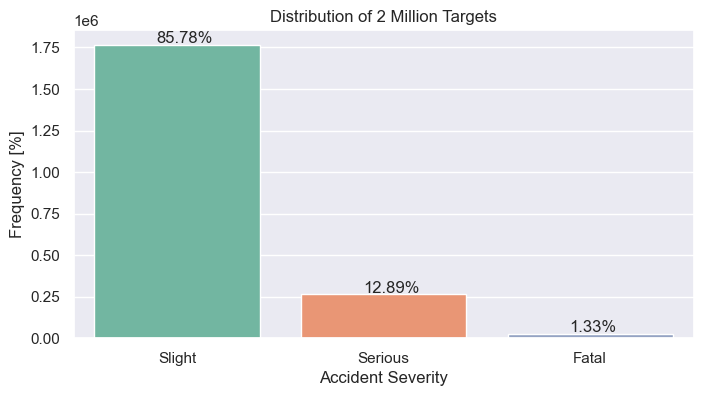

In [8]:
#Distribution of original data by targets

ax = sns.countplot(x = df.Accident_Severity ,palette="Set2")
sns.set(font_scale=1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 2 Million Targets',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()


In [9]:
# Creating weights that are opposite to the weights of target
weights = np.where(df['Accident_Severity'] == 'Slight', .2, .8)

#Sampling only 30% of the data with new weights  
df = df.sample(frac=0.3, replace=True, weights=weights)
print(df.shape)
#df.Accident_Severity.value_counts(normalize=True)

(617522, 57)


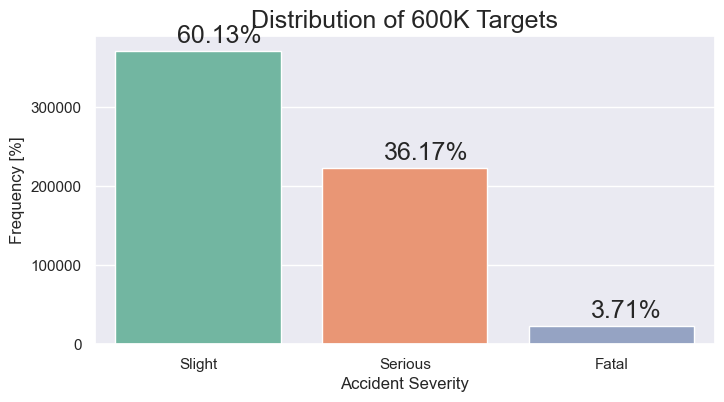

In [10]:
#Distribution of sample data by targets

ax = sns.countplot(x = df.Accident_Severity ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 600K Targets',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()


## **2.3 Check for missing values (NaN)**
### some will be filled, some will get omitted

In [12]:
#Missing values for each column
null_count = df.isnull().sum()
null_count[null_count>0]#.plot('bar', figsize=(30,10))

Age_of_Vehicle                                 102802
Driver_IMD_Decile                              205448
Engine_Capacity_.CC.                            75802
Hit_Object_in_Carriageway                      590090
Hit_Object_off_Carriageway                     555694
make                                            33898
model                                           96189
Propulsion_Code                                 70629
Skidding_and_Overturning                       528767
Vehicle_Location.Restricted_Lane                  285
2nd_Road_Class                                 264630
2nd_Road_Number                                  5775
Carriageway_Hazards                            606410
Did_Police_Officer_Attend_Scene_of_Accident        41
Latitude                                           41
Location_Easting_OSGR                              41
Location_Northing_OSGR                             41
Longitude                                          41
LSOA_of_Accident_Location   

## **2.4 Exploratory Visualization**
### **Age of Vehicle**

Min: 1.0 
Max: 111.0 
Median: 7.0


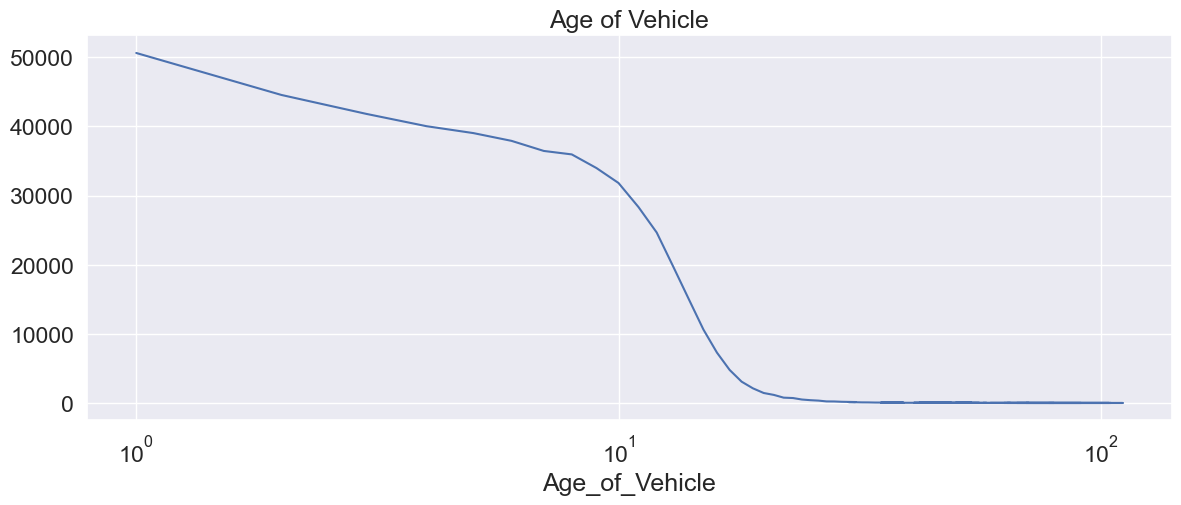

In [14]:
(df.Age_of_Vehicle
 .value_counts()
 .plot(title = "Age of Vehicle", 
       logx = True, 
       figsize=(14,5)))

print('Min:',    df.Age_of_Vehicle.min(), '\n'
      'Max:',    df.Age_of_Vehicle.max(), '\n'
      'Median:', df.Age_of_Vehicle.median())

### **Engine capacity feature**

Min: 6.0 
Max: 91000.0 
Median: 1598.0


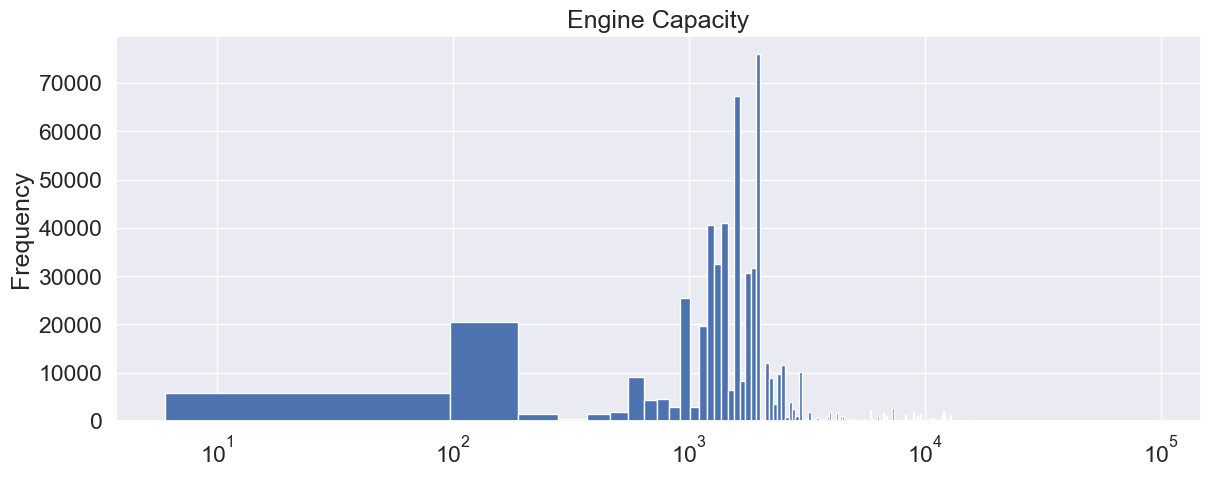

In [16]:
(df['Engine_Capacity_.CC.']
 .plot(kind='hist',  # Use 'kind' as a keyword argument
       bins=1000,
       title="Engine Capacity", 
       figsize=(14, 5),
       logx=True
      ))

print('Min:', df['Engine_Capacity_.CC.'].min(), '\n'
      'Max:', df['Engine_Capacity_.CC.'].max(), '\n'
      'Median:', df['Engine_Capacity_.CC.'].median())


## **2.5 Create a new dataframe** 
### with only the features we need and want, **25 features overall**

In [18]:
df2 = df[['Accident_Index', '1st_Road_Class','Day_of_Week', 'Junction_Detail','Light_Conditions', 'Number_of_Casualties',
          'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit',
          'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Age_of_Vehicle',
          'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'make', 'Engine_Capacity_.CC.', 'Sex_of_Driver',
          'Skidding_and_Overturning', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Accident_Severity'
         ]]

## **Correlation matrix**

In [20]:
print(df2.dtypes)


Accident_Index                 object
1st_Road_Class                 object
Day_of_Week                    object
Junction_Detail                object
Light_Conditions               object
Number_of_Casualties            int64
Number_of_Vehicles              int64
Road_Surface_Conditions        object
Road_Type                      object
Special_Conditions_at_Site     object
Speed_limit                   float64
Time                           object
Urban_or_Rural_Area            object
Weather_Conditions             object
Age_Band_of_Driver             object
Age_of_Vehicle                float64
Hit_Object_in_Carriageway      object
Hit_Object_off_Carriageway     object
make                           object
Engine_Capacity_.CC.          float64
Sex_of_Driver                  object
Skidding_and_Overturning       object
Vehicle_Manoeuvre              object
Vehicle_Type                   object
Accident_Severity              object
dtype: object


## **Number of vehicles distribution**

In [22]:
print(df2.dtypes)
numeric_df = df2.select_dtypes(include=['float64', 'int64'])

# Check for any NaN values and handle them
print(numeric_df.isnull().sum())

# Drop rows with NaN values if necessary
numeric_df.dropna(inplace=True)

Accident_Index                 object
1st_Road_Class                 object
Day_of_Week                    object
Junction_Detail                object
Light_Conditions               object
Number_of_Casualties            int64
Number_of_Vehicles              int64
Road_Surface_Conditions        object
Road_Type                      object
Special_Conditions_at_Site     object
Speed_limit                   float64
Time                           object
Urban_or_Rural_Area            object
Weather_Conditions             object
Age_Band_of_Driver             object
Age_of_Vehicle                float64
Hit_Object_in_Carriageway      object
Hit_Object_off_Carriageway     object
make                           object
Engine_Capacity_.CC.          float64
Sex_of_Driver                  object
Skidding_and_Overturning       object
Vehicle_Manoeuvre              object
Vehicle_Type                   object
Accident_Severity              object
dtype: object
Number_of_Casualties         0
Numbe

In [23]:
# Select only numeric columns
numeric_df = df2.select_dtypes(include=['float64', 'int64'])

# Check for any NaN values and handle them
print(numeric_df.isnull().sum())

# Drop rows with NaN values if necessary
numeric_df.dropna(inplace=True)


Number_of_Casualties         0
Number_of_Vehicles           0
Speed_limit                 21
Age_of_Vehicle          102802
Engine_Capacity_.CC.     75802
dtype: int64


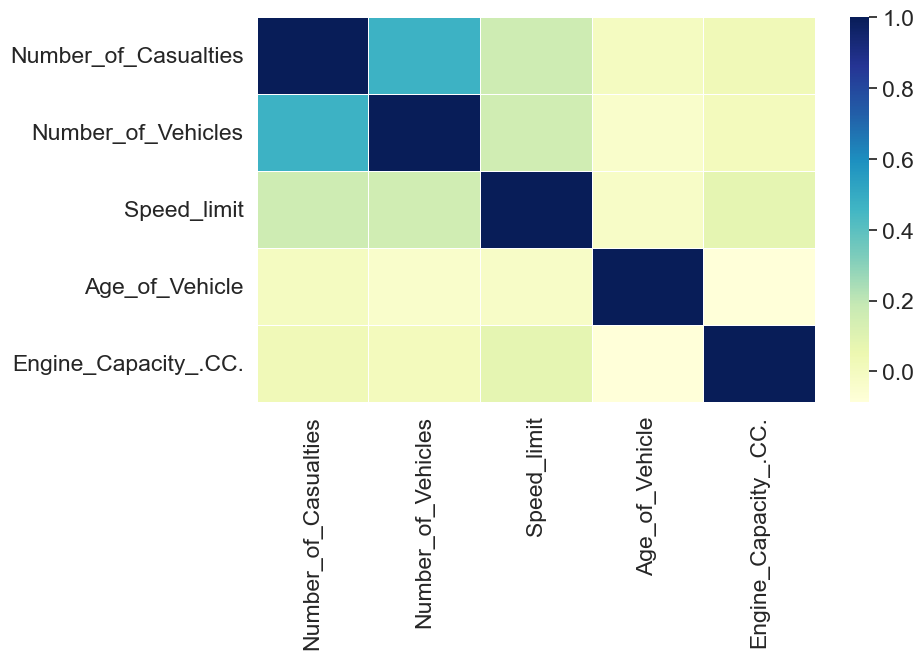

In [24]:
plt.figure(figsize=(9,5))
sns.heatmap(numeric_df.corr(), linewidths=.5, cmap="YlGnBu")
plt.show()

Min: 1 
Max: 67 
Median: 2.0


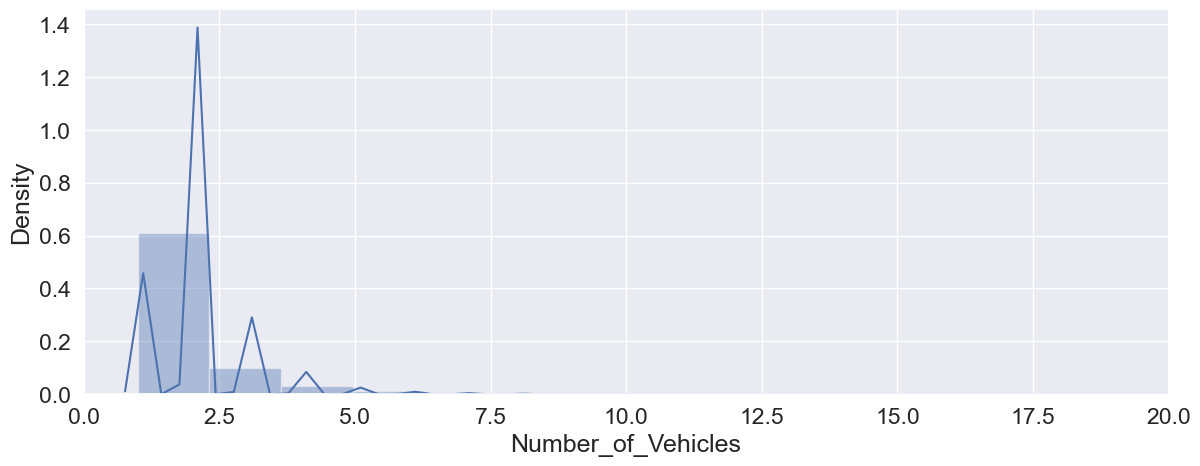

In [25]:
plt.figure(figsize=(14,5))
sns.distplot(df2.Number_of_Vehicles).set_xlim(0,20)
print('Min:',    df2.Number_of_Vehicles.min(), '\n'
      'Max:',    df2.Number_of_Vehicles.max(), '\n'
      'Median:', df2.Number_of_Vehicles.median())

## **Number of casualties distribution**

Min: 1 
Max: 93 
Median: 1.0


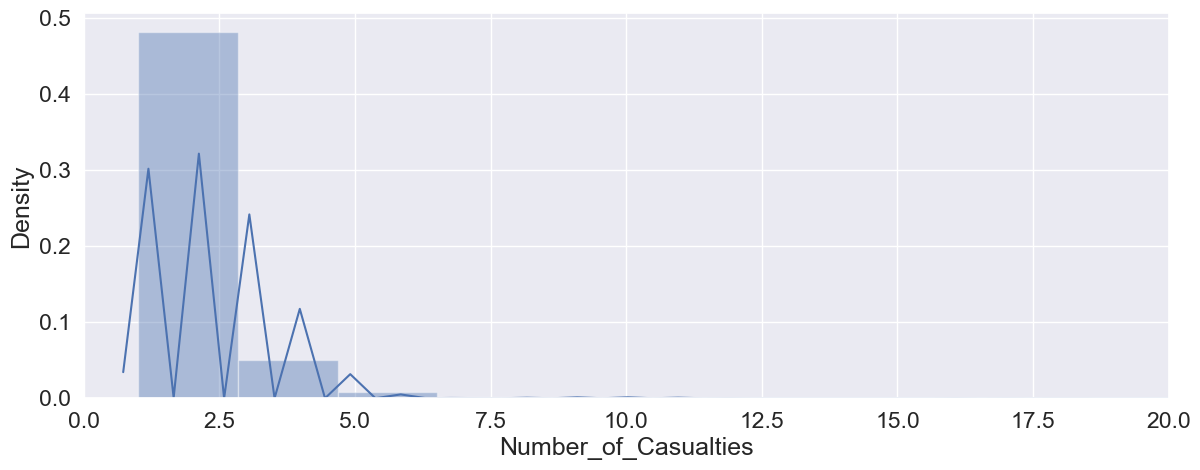

In [27]:
plt.figure(figsize=(14,5))
sns.distplot(df2.Number_of_Casualties).set_xlim(0,20)
print('Min:',    df2.Number_of_Casualties.min(), '\n'
      'Max:',    df2.Number_of_Casualties.max(), '\n'
      'Median:', df2.Number_of_Casualties.median())

## ** Distribution of accidents over the day**

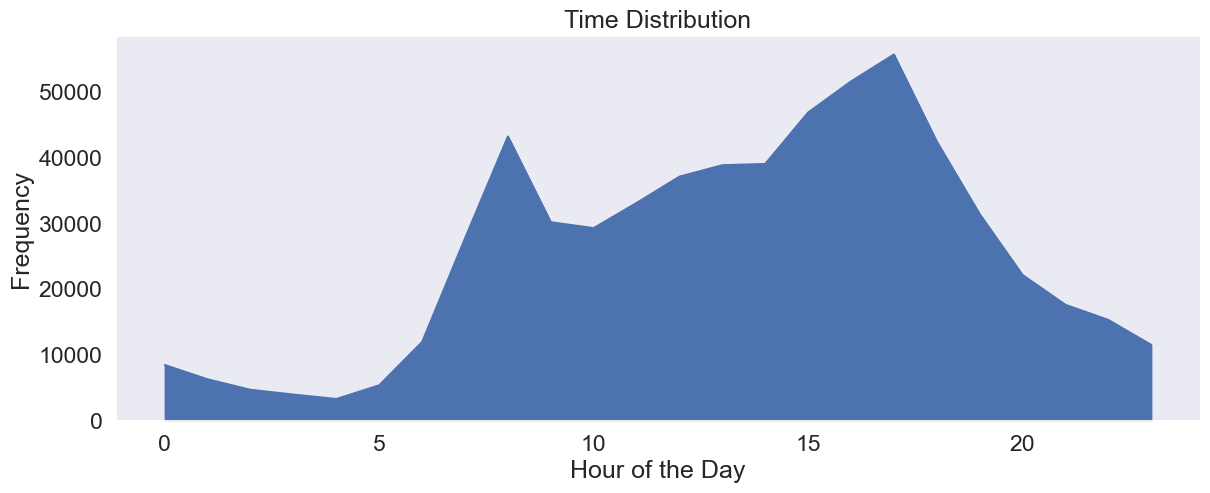

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Time' to datetime and extract the hour
time_x = pd.to_datetime(df2['Time'], format='%H:%M').dt.hour

# Create a figure
plt.figure(figsize=(14, 5))

# Plot using the correct syntax
time_x.value_counts().sort_index().plot(kind='area')

# Show the plot
plt.title('Time Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## **From multiclass to two-classes**

In [31]:
df2['Accident_Severity'] = df2['Accident_Severity'].replace(['Serious', 'Fatal'], 'Serious or Fatal')
df2 = pd.get_dummies(df2, columns=['Accident_Severity'])
df2 = df2.drop('Accident_Severity_Serious or Fatal', axis=1)
df2.Accident_Severity_Slight.value_counts(normalize=True)

Accident_Severity_Slight
True     0.601258
False    0.398742
Name: proportion, dtype: float64

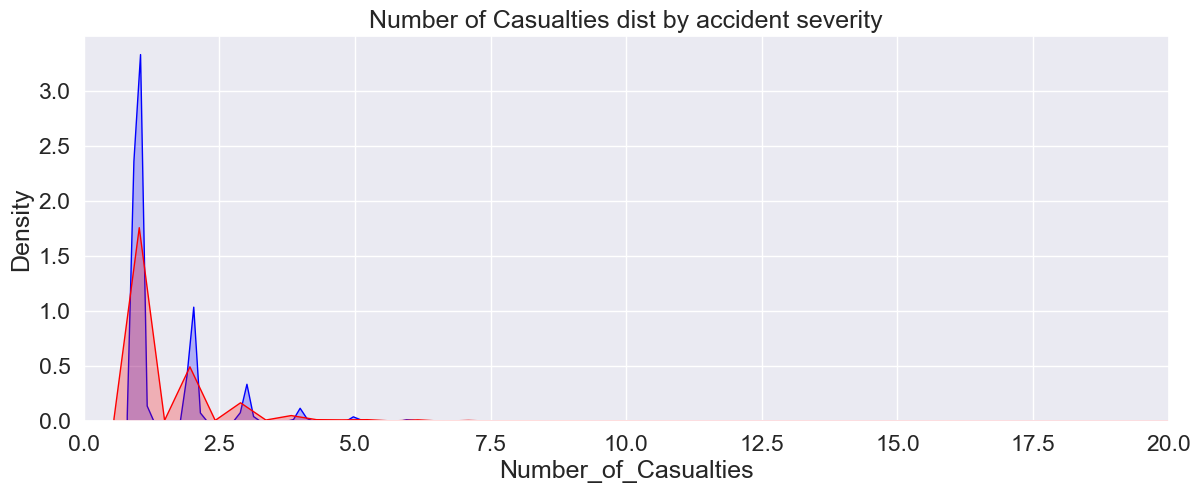

In [32]:
plt.figure(figsize=(14,5))
acc_slight = df2.Accident_Severity_Slight == 1
acc_severe = df2.Accident_Severity_Slight == 0

sns.kdeplot(df2.Number_of_Casualties[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Casualties[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)

plt.title('Number of Casualties dist by accident severity')
plt.show()

#print("we can see distribution between failed (under 2000), and successful (bigger the 2000)")


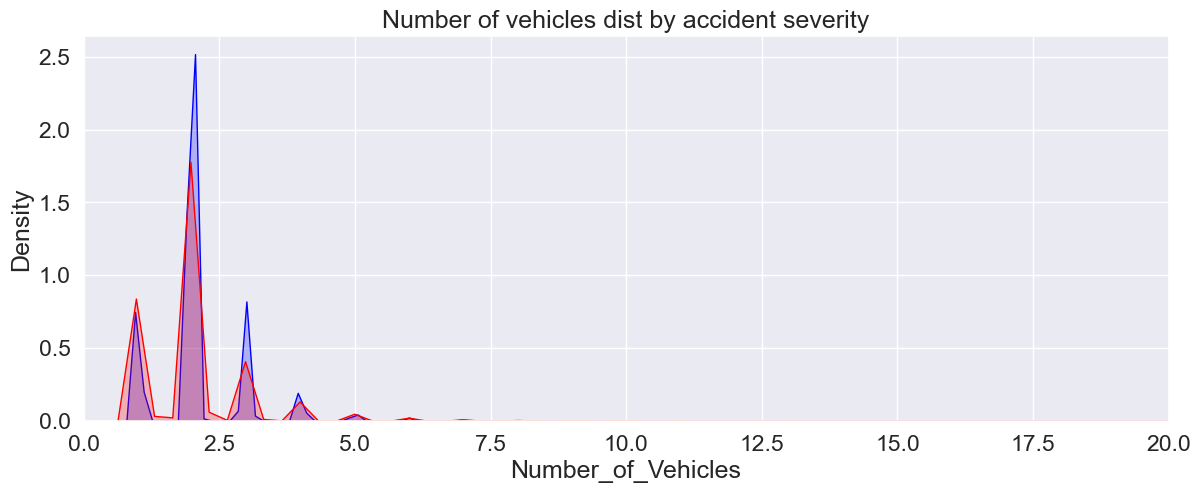

In [33]:
plt.figure(figsize=(14,5))

sns.kdeplot(df2.Number_of_Vehicles[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Vehicles[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)

plt.title('Number of vehicles dist by accident severity')
plt.show()

#print("we can see distribution between failed (under 2000), and successful (bigger the 2000)")


In [34]:
print(df2.dtypes)

Accident_Index                 object
1st_Road_Class                 object
Day_of_Week                    object
Junction_Detail                object
Light_Conditions               object
Number_of_Casualties            int64
Number_of_Vehicles              int64
Road_Surface_Conditions        object
Road_Type                      object
Special_Conditions_at_Site     object
Speed_limit                   float64
Time                           object
Urban_or_Rural_Area            object
Weather_Conditions             object
Age_Band_of_Driver             object
Age_of_Vehicle                float64
Hit_Object_in_Carriageway      object
Hit_Object_off_Carriageway     object
make                           object
Engine_Capacity_.CC.          float64
Sex_of_Driver                  object
Skidding_and_Overturning       object
Vehicle_Manoeuvre              object
Vehicle_Type                   object
Accident_Severity_Slight         bool
dtype: object


In [35]:
df2['Accident_Severity_Slight'] = pd.to_numeric(df2['Accident_Severity_Slight'], errors='coerce')


In [36]:
df2['Accident_Severity_Slight'].fillna(0, inplace=True)  # or use dropna() if appropriate


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=1.4)

(df2.groupby(['Age_Band_of_Driver'])
 .mean()['Accident_Severity_Slight']
 .sort_index()
 .plot.bar(title="Mean Age Band of Driver vs. Accident Severity", ax=axes[0, 0]))

(df2.groupby(['Speed_limit'])
 .mean()['Accident_Severity_Slight']
 .sort_index()
 .plot.bar(title="Mean Speed Limit vs. Accident Severity", ax=axes[0, 1]))

(df2.groupby(['Urban_or_Rural_Area'])
 .mean()['Accident_Severity_Slight']
 .sort_index()
 .plot.bar(title="Mean Urban or Rural Area vs. Accident Severity", ax=axes[1, 0]))


## **2.6 Split features and targets from the data**

In [39]:
X = df2.drop(['Accident_Index','Accident_Severity_Slight'], axis=1)
y = df2.Accident_Severity_Slight
print(X.shape,
      y.shape)

(617522, 23) (617522,)


# **3. Training/Predicting Pipeline**
## **Transform Speed Limit**

In [41]:
def get_Speed_limit(df):
    return df[['Speed_limit']]

FullTransformerOnSpeedLimit = Pipeline([
    ("Select_Speed_Limit", FunctionTransformer(func=get_Speed_limit, validate=False)),
    ("Fill_Null", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("One_Hot_Encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # Changed 'sparse' to 'sparse_output'
])

# Uncomment to fit the transformer
# transformed_data = FullTransformerOnSpeedLimit.fit_transform(X[:5000], y[:5000])

## **Transform Time**

In [43]:
def get_Time(df):
    return pd.to_datetime(df['Time'], format='%H:%M').dt.time

def find_time_group(time_object):
    if time_object<pd.datetime.time(pd.datetime(2000,1,1,5,0)):
        return 'Night'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,7,0)):
        return 'Early Morning'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,10,0)):
        return 'Morning'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,15,0)):
        return 'Midday'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,18,0)):
        return 'Afternoon'
    elif time_object<pd.datetime.time(pd.datetime(2000,1,1,20,0)):
        return 'Evening'
    elif time_object<=pd.datetime.time(pd.datetime(2000,1,1,23,59)):
        return 'Late Evening'
    return np.nan

FullTransformerOnTime = Pipeline([("Select_Time",     FunctionTransformer(func=get_Time, validate=False)),
                                  ("Group_Time",      FunctionTransformer(func=lambda x: x.apply(find_time_group).to_frame(), validate=False)),
                                  ("Fill_Null",       SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                  ("One_Hot_Encoder", OneHotEncoder(sparse_output = False, handle_unknown='ignore'))
                                 ])

#FullTransformerOnTime.fit_transform(X[:5000], y[:5000])

## **Transform Age of Vehicle**

In [45]:
def get_Age_of_Vehicle(df):
    return df[['Age_of_Vehicle']]

FullTransformerOnAgeofVehicle = Pipeline([("Select_Age_of_Vehicle", FunctionTransformer(func=get_Age_of_Vehicle, validate=False)),
                                          ("Fill_Null",             SimpleImputer(missing_values=np.nan, strategy='median'))
                                         ])

#FullTransformerOnAgeofVehicle.fit_transform(X[:5000], y[:5000])

## **Transform Make**

In [47]:
def get_make(df):
    list_of_small_makers = list(df['make'].value_counts()[df['make'].value_counts() < 2000].index)
    return df['make'].replace(list_of_small_makers, 'Other').to_frame()

FullTransformerOnMake = Pipeline([("Select_Make",      FunctionTransformer(func=get_make, validate=False)),
                                   ("Fill_Null",       SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Other')),
                                   ("One_Hot_Encoder", OneHotEncoder(sparse_output = False, handle_unknown='ignore'))])

#FullTransformerOnMake.fit_transform(X[:5000], y[:5000])

## **Transform Engine Capacity**

In [49]:
def get_Engine_Capacity(df):
    return df[['Engine_Capacity_.CC.']]

FullTransformerOnEngineCapacity = Pipeline([("Select_Engine_Capacity",       FunctionTransformer(func=get_Engine_Capacity, validate=False)),
                                            ("Fill_Null",                    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                            ("Car_Types_by_Engine_Capacity", KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')),
                                            ("One_Hot_Encoder",              OneHotEncoder(sparse_output = False, handle_unknown='ignore'))
                                           ])

#FullTransformerOnEngineCapacity.fit_transform(X[:5000], y[:5000])
#FullTransformerOnEngineCapacity.named_steps["Car_Types_by_Engine_Capacity"].bin_edges_[0]

## **Data To OneHot Transformer On Columns**

In [51]:
def get_columns_to_one_hot(df):
    return df[['1st_Road_Class', 'Day_of_Week', 'Junction_Detail', 'Light_Conditions', 'Number_of_Casualties', 
               'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 
               'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Hit_Object_in_Carriageway',
               'Hit_Object_off_Carriageway', 'Sex_of_Driver', 'Skidding_and_Overturning',
               'Vehicle_Manoeuvre', 'Vehicle_Type'
              ]]

DataToOneHotTransformerOnColumns = Pipeline([("Select_Columns",  FunctionTransformer(func=get_columns_to_one_hot, validate=False)),
                                             ("One_Hot_Encoder", OneHotEncoder(sparse_output = False, handle_unknown='ignore'))])

#DataToOneHotTransformerOnColumns.fit_transform(X[:5000], y[:5000])

## **Feature Union**

In [53]:
FeatureUnionTransformer = FeatureUnion([
                                        ("FTAgeofVehicle",   FullTransformerOnAgeofVehicle),
                                        ("FTEngineCapacity", FullTransformerOnEngineCapacity),
                                        ("FTMake",           FullTransformerOnMake),
                                        ("FTSpeedLimit",     FullTransformerOnSpeedLimit),
                                        ("FTTime",           FullTransformerOnTime),
                                        ("OHEColumns",       DataToOneHotTransformerOnColumns)])

#FeatureUnionTransformer.fit_transform(X[:5000], y[:5000])

In [54]:
Full_Transformer = Pipeline([
                           ("Feature_Engineering", FeatureUnionTransformer),
                           ("Min_Max_Transformer", MaxAbsScaler())
                           ])

#Full_Transformer.fit(X[:5000], y[:5000])

# **4. Prediction and submission**

In [56]:
X_train, X_test, y_train, y_test = split(X, y)

## **4.1 Logistic Regression**

In [58]:
from datetime import time
import numpy as np
import pandas as pd

def find_time_group(time_object):
    # Check if the time_object is NaT (Not a Time)
    if pd.isna(time_object):
        return np.nan  # Or return a specific group like 'Unknown'
    
    if time_object < time(5, 0):
        return 'Night'
    elif time_object < time(7, 0):
        return 'Early Morning'
    elif time_object < time(12, 0):
        return 'Morning'
    elif time_object < time(18, 0):
        return 'Afternoon'
    elif time_object < time(22, 0):
        return 'Evening'
    else:
        return 'Late Evening'

# Update the pipeline function
FullTransformerOnTime = Pipeline([
    ("Select_Time", FunctionTransformer(func=get_Time, validate=False)),
    ("Group_Time", FunctionTransformer(func=lambda x: x.apply(find_time_group), validate=False)),
    ("Fill_Null", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("One_Hot_Encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])


In [59]:
%%time

clf = LogisticRegression(class_weight = "balanced")

Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)
clf.fit(X_train_transformed, y_train)

X_test_transformed = Full_Transformer.transform(X_test)

y_pred = clf.predict(X_test_transformed)

print('Classification Report:',classification_report(y_test, y_pred))

print('Score:',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))

Classification Report:               precision    recall  f1-score   support

       False       0.56      0.65      0.60     61583
        True       0.74      0.65      0.69     92798

    accuracy                           0.65    154381
   macro avg       0.65      0.65      0.65    154381
weighted avg       0.67      0.65      0.66    154381

Score: 0.7091986476725551
CPU times: total: 49.7 s
Wall time: 31.2 s


## **4.2 Random Forest Classifier**

In [61]:
%%time

clf = RandomForestClassifier(n_estimators=100, n_jobs=3)

Full_Transformer.fit(X_train)
X_train_transformed = Full_Transformer.transform(X_train)
clf.fit(X_train_transformed, y_train)

X_test_transformed = Full_Transformer.transform(X_test)

y_pred = clf.predict(X_test_transformed)

print('Classification Report:',classification_report(y_test, y_pred))

print('Score:',roc_auc_score(y_test.values, clf.predict_proba(X_test_transformed)[:, 1]))

Classification Report:               precision    recall  f1-score   support

       False       0.78      0.68      0.73     61583
        True       0.80      0.88      0.84     92798

    accuracy                           0.80    154381
   macro avg       0.79      0.78      0.78    154381
weighted avg       0.79      0.80      0.79    154381

Score: 0.8596057173605947
CPU times: total: 3min 45s
Wall time: 1min 59s


## **4.3 Using the Full Estimator**
## Logistic Regression

In [63]:
LogisticRegression_Full_Estimator = Pipeline([
                                              ("Feature_Engineering", FeatureUnionTransformer),
                                              ("Min_Max_Transformer", MaxAbsScaler()),
                                              ("Clf",                 LogisticRegression(class_weight = "balanced"))
                                             ])

#LogisticRegression_Full_Estimator.fit(X[:5000], y[:5000])

In [64]:
%%time

LogisticRegression_Full_Estimator.fit(X_train, y_train)
LogisticRegression_Full_Estimator.predict(X_train)
LogisticRegression_Full_Estimator.predict(X_test)

print('Classification Report:' '\n',
      classification_report(y_test, LogisticRegression_Full_Estimator.predict(X_test)))
print('Score:',roc_auc_score(y_test.values, LogisticRegression_Full_Estimator.predict_proba(X_test)[:, 1]))

Classification Report:
               precision    recall  f1-score   support

       False       0.56      0.65      0.60     61583
        True       0.74      0.65      0.69     92798

    accuracy                           0.65    154381
   macro avg       0.65      0.65      0.65    154381
weighted avg       0.67      0.65      0.66    154381

Score: 0.7091986476725551
CPU times: total: 50.5 s
Wall time: 38.7 s


## Random Forest Classifier

In [66]:
RandomForest_Full_Estimator = Pipeline([
                                        ("Feature_Engineering", FeatureUnionTransformer),
                                        ("Min_Max_Transformer", MaxAbsScaler()),
                                        ("Clf",                 RandomForestClassifier(n_estimators=100, n_jobs=3))
                                       ])

#RandomForest_Full_Estimator.fit(X[:5000], y[:5000])

In [67]:
%%time

RandomForest_Full_Estimator.fit(X_train, y_train)
RandomForest_Full_Estimator.predict(X_train)
RandomForest_Full_Estimator.predict(X_test)

print('Classification Report:' '\n',
      classification_report(y_test, RandomForest_Full_Estimator.predict(X_test)))
print('Score:',roc_auc_score(y_test.values, RandomForest_Full_Estimator.predict_proba(X_test)[:, 1]))

Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.68      0.73     61583
        True       0.80      0.88      0.84     92798

    accuracy                           0.80    154381
   macro avg       0.79      0.78      0.78    154381
weighted avg       0.80      0.80      0.79    154381

Score: 0.8599727597981259
CPU times: total: 4min 1s
Wall time: 2min 23s


In [113]:
scoreTest_RF = []
scoreTrain_RF = []
for number in range(1, 10):
    clf = RandomForestClassifier(max_depth=number, n_estimators=100, n_jobs=3, class_weight="balanced")
    Full_Transformer.fit(X_train)
    X_train_transformed = Full_Transformer.transform(X_train)
    clf.fit(X_train_transformed, y_train)
    X_test_transformed = Full_Transformer.transform(X_test)
    y_score_train = clf.predict_proba(X_train_transformed)[:, 1]
    y_score_test = clf.predict_proba(X_test_transformed)[:, 1]

    scoreTrain_RF.append(round(roc_auc_score(y_train, y_score_train), 3))
    scoreTest_RF.append(round(roc_auc_score(y_test, y_score_test), 3))


In [68]:
#%%time
#scoreTest_RF = []
#scoreTrain_RF = []
#for number in range(1,10):
#    clf = RandomForestClassifier(max_depth = number,n_estimators = 100, n_jobs=3, class_weight = "balanced")
#    Full_Transformer.fit(X_train)
#    X_train_transformed = Full_Transformer.transform(X_train)
#    clf.fit(X_train_transformed, y_train)
#    X_test_transformed = Full_Transformer.transform(X_test)
#    y_score_train = clf.predict_proba(X_train_transformed)[:,1]
#    y_score_test = clf.predict_proba(X_test_transformed)[:,1]
#
#    scoreTrain_RF.append(round(roc_auc_score(y_train, y_score_train) , 3))
#    scoreTest_RF.append(round(roc_auc_score(y_test, y_score_test) , 3))
    

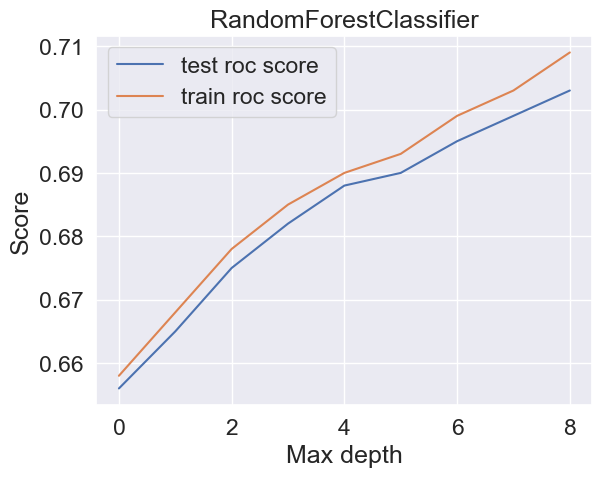

In [115]:
pd.DataFrame({'test roc score': scoreTest_RF, 'train roc score': scoreTrain_RF}).plot(grid=True)
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.title("RandomForestClassifier")
plt.show()

In [69]:
#pd.DataFrame({'test roc score':scoreTest_RF,'train roc score':scoreTrain_RF}).plot(grid = True)
#plt.xlabel('Max depth')
#plt.ylabel('Score')
#plt.title("RandomForestClassifier")
#plt.show()

In [119]:
%%time
# Initialize the RandomForestClassifier with the optimal max_depth
cls_RF = RandomForestClassifier(max_depth=np.array(scoreTest_RF).argmax(), n_estimators=100, n_jobs=3, class_weight="balanced")

# Fit the transformer to the training data
Full_Transformer.fit(X_train)

# Transform the training data
X_train_transformed = Full_Transformer.transform(X_train)

# Fit the RandomForestClassifier
cls_RF.fit(X_train_transformed, y_train)

# Transform the test data
X_test_transformed = Full_Transformer.transform(X_test)

# Predict probabilities for training and test sets
train_proba = cls_RF.predict_proba(X_train_transformed)[:, 1]
test_proba = cls_RF.predict_proba(X_test_transformed)[:, 1]

# Calculate ROC AUC scores
print("RF roc_train:", round(roc_auc_score(y_train, train_proba), 3))
print("RF roc_test:", round(roc_auc_score(y_test, test_proba), 3))

# Cross-validation score
print('RF_cross_score:', cross_val_score(cls_RF, X_train_transformed, y_train, cv=5, scoring='roc_auc').mean())



RF roc_train: 0.703
RF roc_test: 0.698


NameError: name 'cross_val_score' is not defined

In [70]:
#%%time
#cls_RF = RandomForestClassifier(max_depth = np.array(scoreTest_RF).argmax(),n_estimators = 100, n_jobs=3, class_weight = "balanced")
#Full_Transformer.fit(X_train)
#X_train_transformed = Full_Transformer.transform(X_train)
#clf.fit(X_train_transformed, y_train)
#X_test_transformed = Full_Transformer.transform(X_test)
#
#print("RF roc_train:",round(roc_auc_score(y_train, cls_RF.predict_proba(X_train_transformed)[:,1]) , 3))
#print("RF roc_test:",round(roc_auc_score(y_test, cls_RF.predict_proba(X_test_transformed)[:,1]) , 3))
#
#print('RF_cross_score:', cross_val_score(cls_RF, X_train_transformed, y_train, cv=5, scoring='roc_auc').mean())